<a href="https://colab.research.google.com/github/elsaflts/Laser-beam-propagation-from-a-laser-pointer-to-the-moon-/blob/main/Crank_Nicolson_Gaussian_Propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Physical Space implementation of CN**
We first implement the Crank-Nicolson algorithm in physical space. We wish to implement it using cylindrical coordiantes using the *paraxial propagation equation* for the envelope of the laser beam $\tilde{E}$
\begin{equation}
\frac{\partial \tilde{E}}{\partial \tilde{z}} = \frac{i}{2k_0} \nabla^2_{\tilde{\perp}} \tilde{E},
\end{equation}
where $\nabla_{\perp} \equiv \partial^2_{\tilde{r}} + (1/\tilde{r}) \partial_\tilde{r}$.

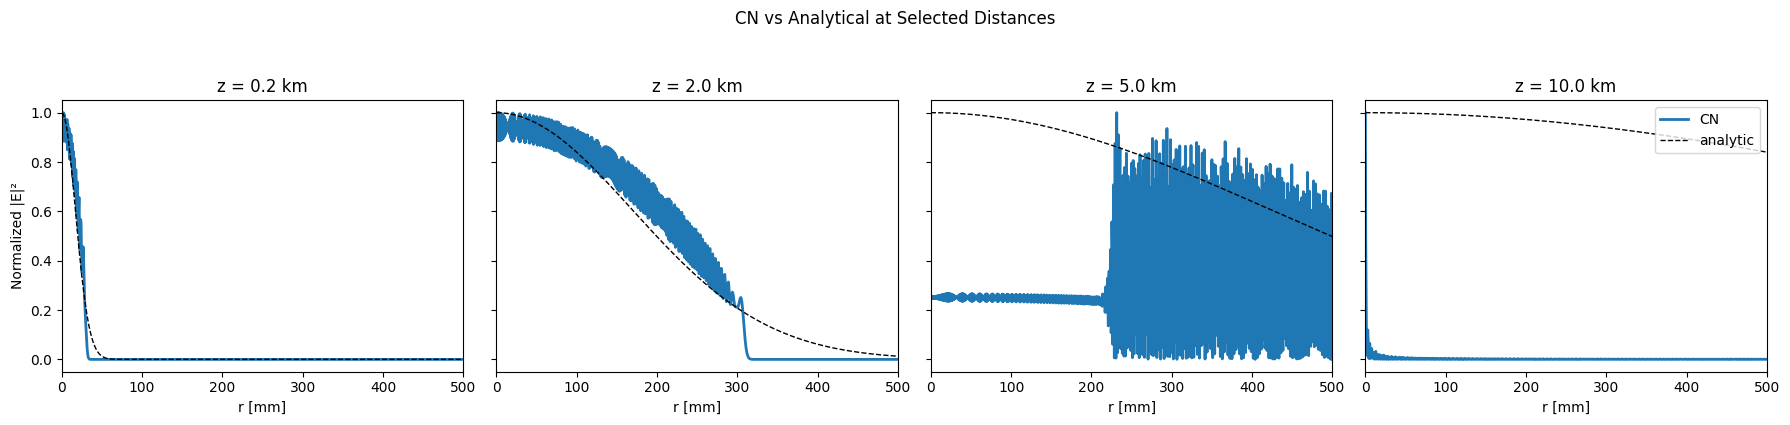

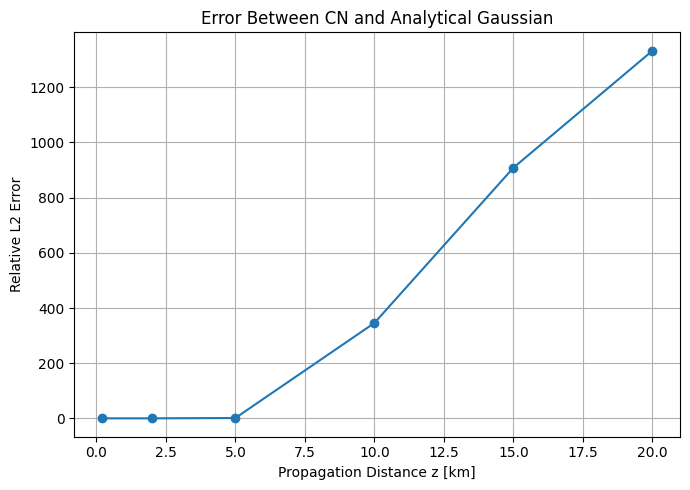

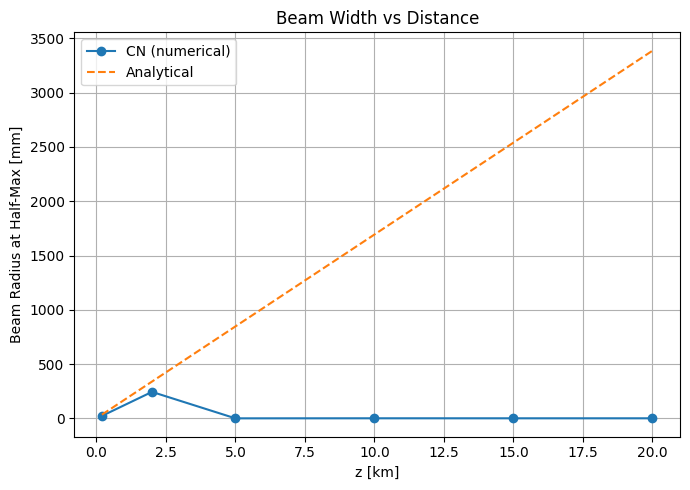

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

# Parameters
lam = 532e-9
w0 = 1e-3
k0 = 2 * np.pi / lam
r_max = 0.5
Nr = 1000
dz = 2.0
dr = r_max / Nr
r = np.linspace(0, r_max, Nr + 1)

# Laplacian coefficients
α = 1j * dz / (4 * k0)
am = np.zeros(Nr)
a0 = np.zeros(Nr + 1)
ap = np.zeros(Nr)

j = np.arange(1, Nr)
rj = j * dr
ap[j] = 1 / dr**2 + 1 / (2 * rj * dr)
am[j - 1] = 1 / dr**2 - 1 / (2 * rj * dr)
a0[j] = -2 / dr**2
a0[0] = -2 / dr**2
ap[0] = 2 / dr**2
a0[-1] = 0
am[-1] = ap[-1] = 0

# CN Matrices
ab_A = np.vstack([
    np.hstack(([0], -α * ap)),
    1 - α * a0,
    np.hstack((-α * am, [0]))
])
ab_B = np.vstack([
    np.hstack(([0], α * ap)),
    1 + α * a0,
    np.hstack((α * am, [0]))
])
ab_A[0, -1] = ab_A[2, -1] = 0.0
ab_A[1, -1] = 1.0
ab_B[:, -1] = 0.0
ab_B[1, -1] = 1.0

E0 = np.exp(-(r / w0)**2)

# Precise propagation at target distances
def propagate_exact(E0, z_targets, dz, ab_A, ab_B):
    steps = int(np.ceil(max(z_targets) / dz))
    E = E0.copy().astype(complex)
    out = {}
    z = 0.0
    for step in range(steps + 1):
        if np.isclose(z, z_targets, atol=dz / 2).any():
            out[round(z, 1)] = np.abs(E)**2
        rhs = ab_B[1] * E.copy()
        rhs[:-1] += ab_B[0, 1:] * E[1:]
        rhs[1:] += ab_B[2, :-1] * E[:-1]
        E = solve_banded((1, 1), ab_A, rhs)
        z += dz
    return out

# Analytic solution
def w(z): return w0 * np.sqrt(1 + (z / (np.pi * w0**2 / lam))**2)
def I_analytic(r, z): return (w0 / w(z))**2 * np.exp(-2 * r**2 / w(z)**2)
def beam_radius(I, r): return np.interp(0.5, (I / np.max(I))[::-1], r[::-1])

# Run simulation
z_targets = [200.0, 2000.0, 5000.0, 10000.0, 15000.0, 20000.0]
profiles = propagate_exact(E0, z_targets, dz, ab_A, ab_B)

# Plot 1: CN vs analytic at selected distances
selected_z_vals = [200.0, 2000.0, 5000.0, 10000.0]
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)
for ax, z in zip(axes, selected_z_vals):
    num = profiles[z]
    ana = I_analytic(r, z)
    ax.plot(r * 1e3, num / num.max(), lw=2, label='CN')
    ax.plot(r * 1e3, ana / ana.max(), 'k--', lw=1, label='analytic')
    ax.set_title(f"z = {z/1000:.1f} km")
    ax.set_xlim(0, 500)
    ax.set_xlabel("r [mm]")
axes[0].set_ylabel("Normalized |E|²")
axes[-1].legend(loc="upper right")
fig.suptitle("CN vs Analytical at Selected Distances", y=1.05)
plt.tight_layout()
plt.show()

# Plot 2: Relative error vs distance
errors = [np.linalg.norm(profiles[z] - I_analytic(r, z)) / np.linalg.norm(I_analytic(r, z)) for z in z_targets]
plt.figure(figsize=(7, 5))
plt.plot(np.array(z_targets) / 1e3, errors, 'o-')
plt.xlabel("Propagation Distance z [km]")
plt.ylabel("Relative L2 Error")
plt.title("Error Between CN and Analytical Gaussian")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Beam width vs distance
widths_num = [beam_radius(profiles[z], r) for z in z_targets]
widths_ana = [w(z) for z in z_targets]

plt.figure(figsize=(7, 5))
plt.plot(np.array(z_targets) / 1e3, np.array(widths_num) * 1e3, 'o-', label="CN (numerical)")
plt.plot(np.array(z_targets) / 1e3, np.array(widths_ana) * 1e3, '--', label="Analytical")
plt.xlabel("z [km]")
plt.ylabel("Beam Radius at Half-Max [mm]")
plt.title("Beam Width vs Distance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Part 2: Computational space implementation

We can transform our initial paraxial propagation equation to
\begin{equation}
\frac{\partial C}{\partial \zeta} = \frac{i}{4} \nabla_{\xi}^{2} C + i [1 - \xi^2] C
\end{equation}
which is equivalent in what we will call the "computational space".

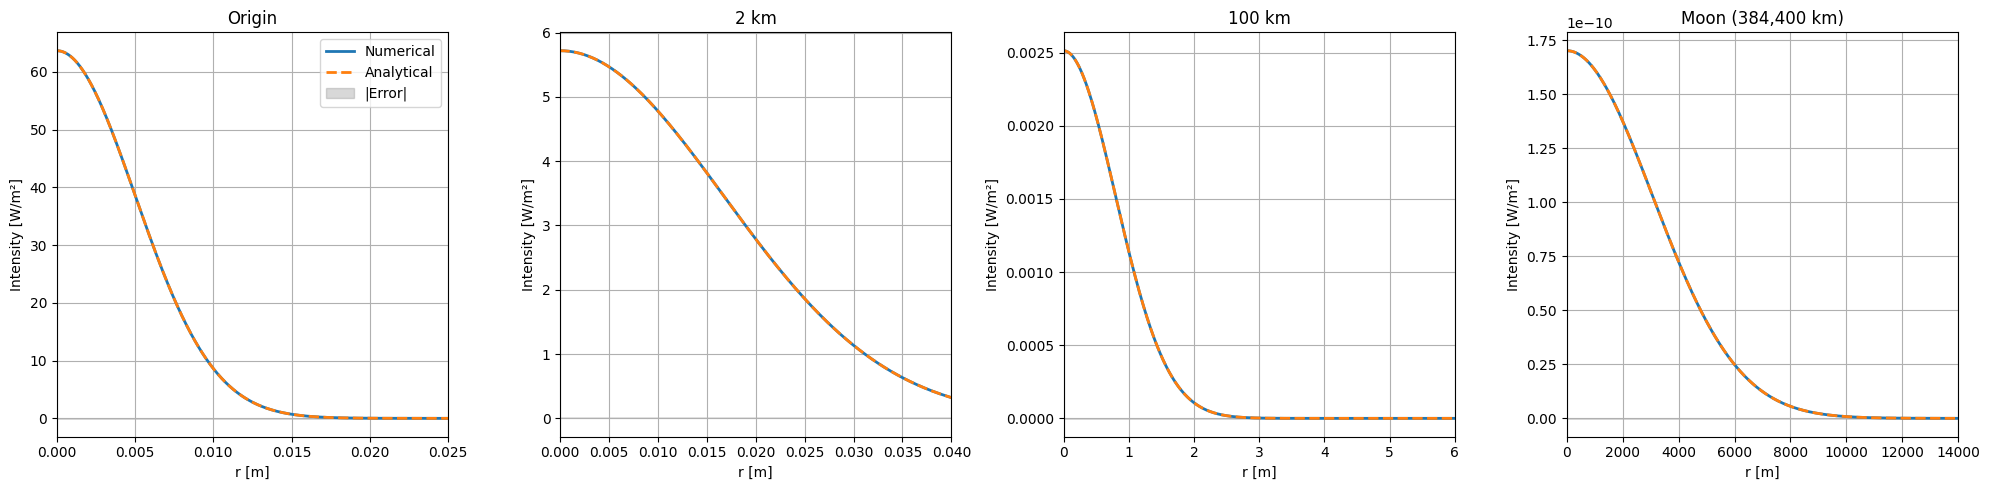

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu

# ------------------- 1. PARAMETERS --------------------
λ = 500e-9                       # Wavelength [m]
k0 = 2 * np.pi / λ              # Wavenumber
wf = 1e-2                       # Beam waist [m]
P0 = 1e-2                       # Power [W]
Ef = 1 / wf * np.sqrt(2 * P0 / np.pi)  # Amplitude at focus
zf = k0 * wf**2 / 2             # Rayleigh range [m]

# ------------------- 2. COMPUTATIONAL GRID --------------------
J = 2048
xi_size = 10
xi = np.linspace(-xi_size / 2, xi_size / 2, J)
dx = xi[1] - xi[0]

distance = 384400e3            # Target distance (Moon)
N = 20000
zeta_max = np.arctan(distance / zf)
dt = zeta_max / (N - 1)
sigma = 1j * dt / (4 * dx**2)

# ------------------- 3. INITIAL CONDITION --------------------
C = np.exp(-xi**2)
s = [C.copy()]

# ------------------- 4. ABSORBING GAUSSIAN MASK --------------------
taper = np.ones(J)
edge_width = int(0.1 * J)
window = np.hanning(2 * edge_width)
taper[:edge_width] = window[:edge_width]
taper[-edge_width:] = window[-edge_width:]

# ------------------- 5. CRANK-NICOLSON MATRICES --------------------
main_A = (1 + 2 * sigma) - 1j * dt * (1 - xi**2)
main_B = (1 - 2 * sigma) + 1j * dt * (1 - xi**2)
off_A = np.full(J - 1, -sigma)
off_B = np.full(J - 1, sigma)
off_A[0] = off_A[-1] = -2 * sigma
off_B[0] = off_B[-1] = 2 * sigma

A_sparse = diags([off_A, main_A, off_A], [-1, 0, 1], format='csc')
B_sparse = diags([off_B, main_B, off_B], [-1, 0, 1], format='csc')
A_lu = splu(A_sparse)

# ------------------- 6. TIME PROPAGATION --------------------
for _ in range(N - 1):
    rhs = B_sparse @ (C * taper)
    C = A_lu.solve(rhs)
    s.append(C.copy())

# ------------------- 7. UTILITY FUNCTIONS --------------------
def x(z_tilda, xi):
    return xi * np.sqrt(1 + (z_tilda**2 / zf**2)) * wf

def translate(z_tilda, s):
    z = z_tilda / zf
    zeta = np.arctan(z)
    j = int(zeta / dt)
    j = min(j, len(s) - 1)
    C_val = s[j]
    E = 1 / np.sqrt(1 + z**2) * np.exp(1j * (xi**2 * (1 + z**2) / (z + 1 / z) - zeta))
    return np.abs(C_val * Ef * E)**2

def analytical(r, z):
    wz = wf * np.sqrt(1 + (z / zf)**2)
    return (2 * P0 / (np.pi * wz**2)) * np.exp(-2 * r**2 / wz**2)

# ------------------- 8. PLOT + ERROR VISUALIZATION --------------------
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
distances = [1e-7, 2e3, 1e5, 384400e3]
titles = ["Origin", "2 km", "100 km", "Moon (384,400 km)"]
xlims = [(0, 0.025), (0, 0.04), (0, 6), (0, 14000)]

for ax, z_val, title, xlim in zip(axes, distances, titles, xlims):
    r_vals = x(z_val, xi)
    I_num = translate(z_val, s)
    I_ana = analytical(r_vals, z_val)
    ax.plot(r_vals, I_num, label="Numerical", lw=2)
    ax.plot(r_vals, I_ana, '--', label="Analytical", lw=2)
    ax.fill_between(r_vals, np.abs(I_num - I_ana), color='gray', alpha=0.3, label='|Error|' if z_val == distances[0] else "")
    ax.set_title(f"{title}")
    ax.set_xlim(xlim)
    ax.set_xlabel("r [m]")
    ax.set_ylabel("Intensity [W/m²]")
    ax.grid(True)
    if z_val == distances[0]:
        ax.legend()

plt.tight_layout()
plt.show()

# Part 3: Tests
- Intensity depending on different wavelength
- Wavelength and spot size relation
- Intensity and initial waist size
- Intensity and laser power

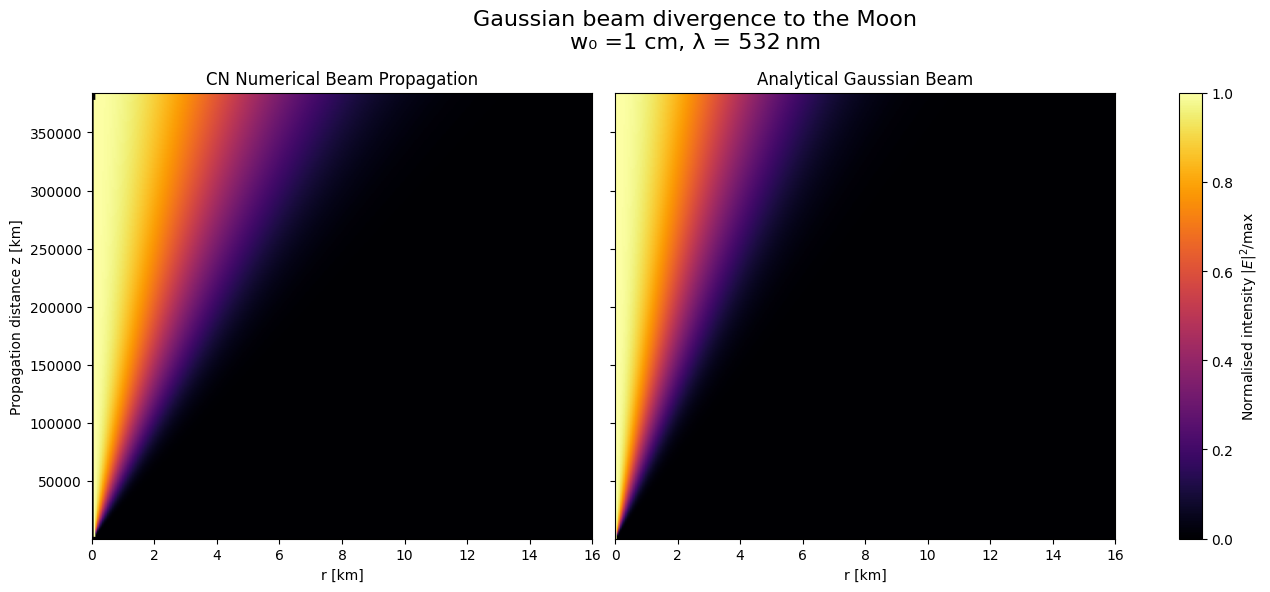

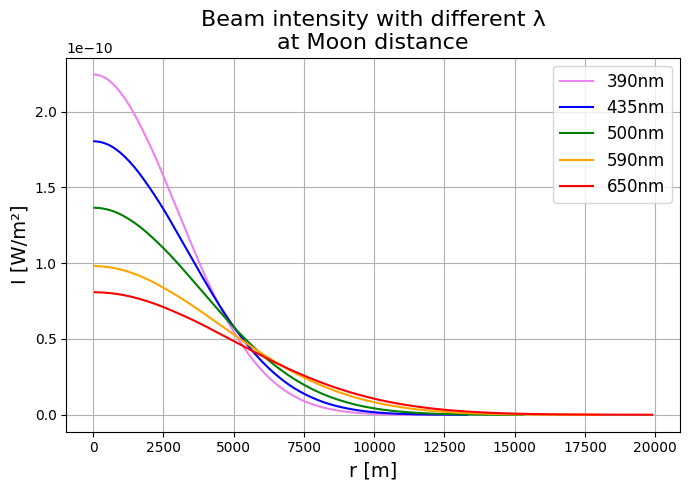

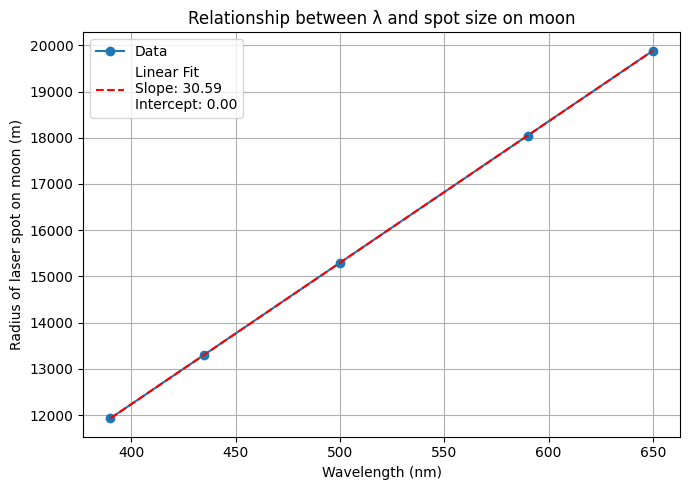

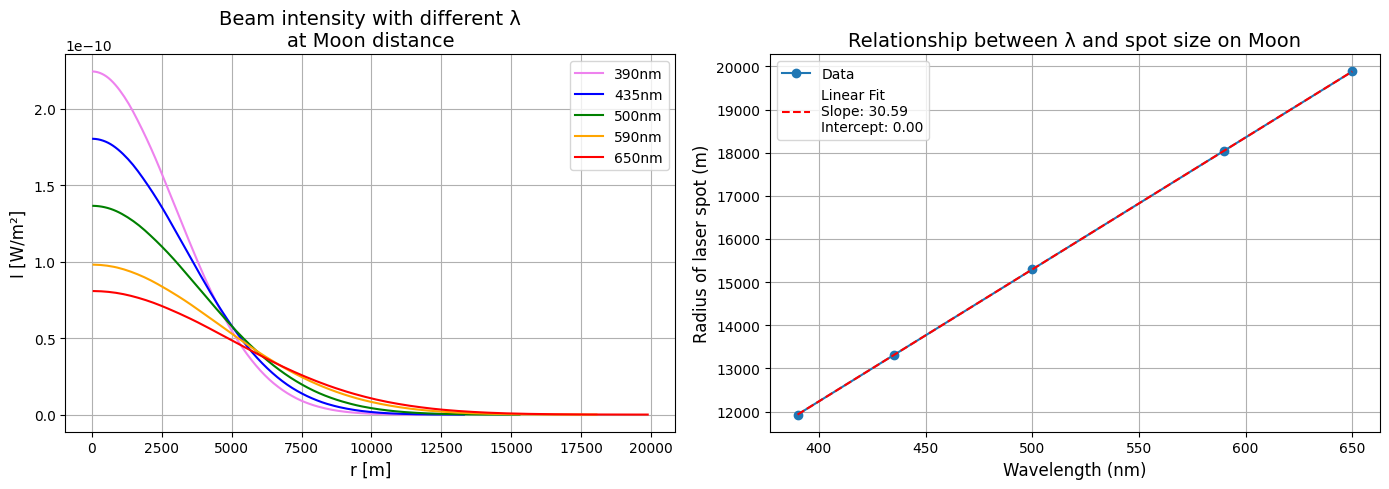

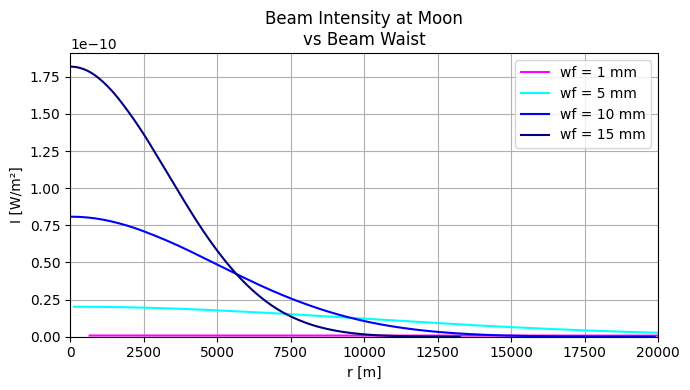

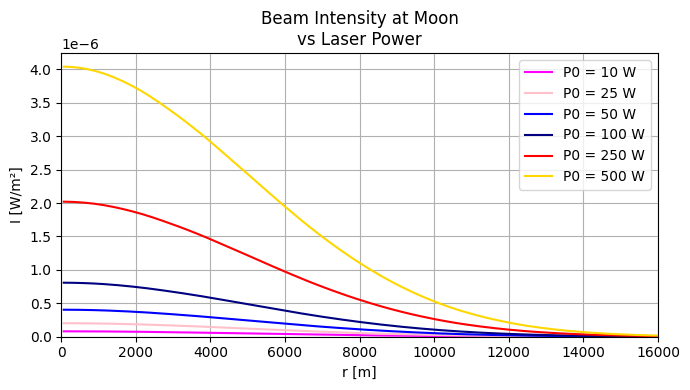

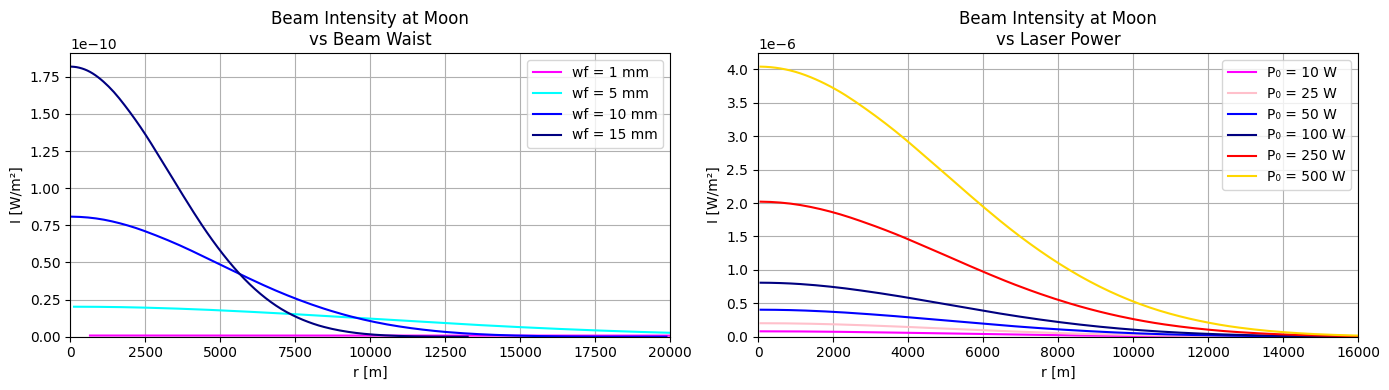

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu

# --------------------------------------------------------------------------------
# PARAMETERS
# --------------------------------------------------------------------------------
λ = 532e-9                          # Wavelength [m]
k0 = 2 * np.pi / λ
wf = 1e-2                           # Beam waist [m]
P0 = 1e-2                           # Power [W]
Ef = 1 / wf * np.sqrt(2 * P0 / np.pi)
zf = k0 * wf**2 / 2                 # Rayleigh length [m]

# --------------------------------------------------------------------------------
# COMPUTATIONAL SETUP
# --------------------------------------------------------------------------------
J = 300
xi_size = 5
xi = np.linspace(-xi_size / 2, xi_size / 2, J)
dx = xi[1] - xi[0]
distance_max = 384400e3
N = 1000
zeta_max = np.arctan(distance_max / zf)
dt = zeta_max / (N - 1)
D = 1j / 4
sigma = D * dt / dx**2

C0 = np.exp(-xi**2)

main_A = (1 + 2 * sigma) - 1j * dt * (1 - xi**2) / 2
main_B = (1 - 2 * sigma) + 1j * dt * (1 - xi**2) / 2
off_A = np.full(J - 1, -sigma)
off_B = np.full(J - 1, sigma)
off_A[0] = off_A[-1] = -2 * sigma
off_B[0] = off_B[-1] = 2 * sigma

A_sparse = diags([off_A, main_A, off_A], [-1, 0, 1], format='csc')
B_sparse = diags([off_B, main_B, off_B], [-1, 0, 1], format='csc')
A_lu = splu(A_sparse)

C = C0.copy()
s = [C.copy()]
for _ in range(N - 1):
    rhs = B_sparse @ C
    C = A_lu.solve(rhs)
    s.append(C.copy())

# --------------------------------------------------------------------------------
# UTILITY FUNCTIONS
# --------------------------------------------------------------------------------
def x(z_tilda, xi):
    return xi * np.sqrt(1 + (z_tilda**2 / zf**2)) * wf

def translate(z_tilda, s):
    z = z_tilda / zf
    zeta = np.arctan(z)
    j = int(zeta / dt)
    j = min(j, len(s) - 1)
    C = s[j]
    E = 1 / np.sqrt(1 + z**2) * np.exp(1j * (xi**2 * (1 + z**2) / (z + 1 / z) - zeta))
    return np.abs(C * Ef * E)**2

# --------------------------------------------------------------------------------
# NUMERICAL 2D INTENSITY MAP
# --------------------------------------------------------------------------------
z_vals = np.linspace(1e3, distance_max, 400)
r_vals = np.linspace(0, 16000, 300)
intensity_map = np.zeros((len(z_vals), len(r_vals)))

for i, z in enumerate(z_vals):
    I = translate(z, s)
    r_at_z = x(z, xi)
    I_interp = np.interp(r_vals, r_at_z[r_at_z >= 0], I[r_at_z >= 0], left=0, right=0)
    intensity_map[i] = I_interp / np.max(I_interp) if np.max(I_interp) > 0 else 0

# --------------------------------------------------------------------------------
# ANALYTICAL 2D INTENSITY MAP
# --------------------------------------------------------------------------------
def analytical_intensity(r, z):
    wz = wf * np.sqrt(1 + (z / zf)**2)
    return np.exp(-2 * r**2 / wz**2)

intensity_map_analytic = np.zeros_like(intensity_map)
for i, z in enumerate(z_vals):
    I = analytical_intensity(r_vals, z)
    intensity_map_analytic[i] = I / np.max(I)

# --------------------------------------------------------------------------------
# PLOT: NUMERICAL vs ANALYTICAL
# --------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle(f'Gaussian beam divergence to the Moon\nw₀ ={wf*100:.0f} cm, λ = {int(λ*1e9)} nm', fontsize=16)
extent = [r_vals[0]/1e3, r_vals[-1]/1e3, z_vals[0]/1e3, z_vals[-1]/1e3]

axes[0].imshow(intensity_map, extent=extent, origin='lower', aspect='auto', cmap='inferno', vmin=0, vmax=1)
axes[0].set_title("CN Numerical Beam Propagation")
axes[0].set_xlabel("r [km]")
axes[0].set_ylabel("Propagation distance z [km]")

im = axes[1].imshow(intensity_map_analytic, extent=extent, origin='lower', aspect='auto', cmap='inferno', vmin=0, vmax=1)
axes[1].set_title("Analytical Gaussian Beam")
axes[1].set_xlabel("r [km]")



plt.tight_layout()
fig.colorbar(im, ax=axes.ravel().tolist(), label="Normalised intensity $|E|^2 / \max$")
plt.show()

# --------------------------------------------------------------------------------
# PLOTS: WAVELENGTH EFFECTS AT MOON
# --------------------------------------------------------------------------------
wavelengths = [390e-9, 435e-9, 500e-9, 590e-9, 650e-9]
colors = ['violet', 'blue', 'green', 'orange', 'red']
labels = ['390nm', '435nm', '500nm', '590nm', '650nm']
spot_sizes, r_vals_all, intensities_all = [], [], []

for lmd in wavelengths:
    k0 = 2 * np.pi / lmd
    zf = k0 * wf**2 / 2
    zeta_max = np.arctan(384400e3 / zf)
    dt = zeta_max / (N - 1)
    D = 1j / 4
    sigma = D * dt / dx**2

    main_A = (1 + 2 * sigma) - 1j * dt * (1 - xi**2) / 2
    main_B = (1 - 2 * sigma) + 1j * dt * (1 - xi**2) / 2
    off_A = np.full(J - 1, -sigma)
    off_B = np.full(J - 1, sigma)
    off_A[0] = off_A[-1] = -2 * sigma
    off_B[0] = off_B[-1] = 2 * sigma

    A_sparse = diags([off_A, main_A, off_A], [-1, 0, 1], format='csc')
    B_sparse = diags([off_B, main_B, off_B], [-1, 0, 1], format='csc')
    A_lu = splu(A_sparse)

    C = np.exp(-xi**2)
    s_local = [C.copy()]
    for _ in range(N - 1):
        rhs = B_sparse @ C
        C = A_lu.solve(rhs)
        s_local.append(C.copy())

    def translate_custom(z_tilda, s, lmd):
        k0_local = 2 * np.pi / lmd
        zf_local = k0_local * wf**2 / 2
        z = z_tilda / zf_local
        zeta = np.arctan(z)
        j = int(zeta / dt)
        j = min(j, len(s) - 1)
        C = s[j]
        E = 1 / np.sqrt(1 + z**2) * np.exp(1j * (xi**2 * (1 + z**2) / (z + 1 / z) - zeta))
        return np.abs(C * Ef * E)**2

    r_vals = x(384400e3, xi)
    I_vals = translate_custom(384400e3, s_local, lmd)
    r_vals_all.append(r_vals)
    intensities_all.append(I_vals)
    half_max = np.max(I_vals) / 2
    spot_radius = np.interp(half_max, I_vals[::-1], r_vals[::-1])
    spot_sizes.append(np.abs(spot_radius))

# Plot intensity profiles
plt.figure(figsize=(7, 5))
for i in range(len(wavelengths)):
    r_pos = r_vals_all[i] >= 0
    plt.plot(r_vals_all[i][r_pos], intensities_all[i][r_pos], label=labels[i], color=colors[i])
plt.title("Beam intensity with different λ\nat Moon distance", fontsize=16)
plt.xlabel("r [m]", fontsize=14)
plt.ylabel("I [W/m²]", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot radius vs. wavelength
wavelengths_nm = [l * 1e9 for l in wavelengths]
plt.figure(figsize=(7, 5))
plt.plot(wavelengths_nm, spot_sizes, 'o-', label='Data')
fit = np.polyfit(wavelengths_nm, spot_sizes, 1)
fit_fn = np.poly1d(fit)
plt.plot(wavelengths_nm, fit_fn(wavelengths_nm), 'r--', label=f'Linear Fit\nSlope: {fit[0]:.2f}\nIntercept: {fit[1]:.2f}')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Radius of laser spot on moon (m)")
plt.title("Relationship between λ and spot size on moon")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# First plot: intensity profiles at Moon distance
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for i in range(len(wavelengths)):
    r_pos = r_vals_all[i] >= 0
    axs[0].plot(r_vals_all[i][r_pos], intensities_all[i][r_pos], label=labels[i], color=colors[i])

axs[0].set_title("Beam intensity with different λ\nat Moon distance", fontsize=14)
axs[0].set_xlabel("r [m]", fontsize=12)
axs[0].set_ylabel("I [W/m²]", fontsize=12)
axs[0].legend(fontsize=10)
axs[0].grid(True)

# Second plot: wavelength vs spot size
wavelengths_nm = [l * 1e9 for l in wavelengths]
axs[1].plot(wavelengths_nm, spot_sizes, 'o-', label='Data')
fit = np.polyfit(wavelengths_nm, spot_sizes, 1)
fit_fn = np.poly1d(fit)
axs[1].plot(wavelengths_nm, fit_fn(wavelengths_nm), 'r--', label=f'Linear Fit\nSlope: {fit[0]:.2f}\nIntercept: {fit[1]:.2f}')

axs[1].set_title("Relationship between λ and spot size on Moon", fontsize=14)
axs[1].set_xlabel("Wavelength (nm)", fontsize=12)
axs[1].set_ylabel("Radius of laser spot (m)", fontsize=12)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# --------------------------------------------------------------------------------
# PLOTS: EFFECT OF BEAM WAIST AND POWER
# --------------------------------------------------------------------------------
def cn_simulate(wf, P0):
    zf = k0 * wf**2 / 2
    Ef = 1 / wf * np.sqrt(2 * P0 / np.pi)
    zeta_max = np.arctan(distance_max / zf)
    dt = zeta_max / (N - 1)
    sigma = D * dt / dx**2
    main_A = (1 + 2 * sigma) - 1j * dt * (1 - xi**2) / 2
    main_B = (1 - 2 * sigma) + 1j * dt * (1 - xi**2) / 2
    off_A = np.full(J - 1, -sigma)
    off_B = np.full(J - 1, sigma)
    off_A[0] = off_A[-1] = -2 * sigma
    off_B[0] = off_B[-1] = 2 * sigma
    A_sparse = diags([off_A, main_A, off_A], [-1, 0, 1], format='csc')
    B_sparse = diags([off_B, main_B, off_B], [-1, 0, 1], format='csc')
    A_lu = splu(A_sparse)
    C = np.exp(-xi**2)
    s = [C.copy()]
    for _ in range(N - 1):
        rhs = B_sparse @ C
        C = A_lu.solve(rhs)
        s.append(C.copy())
    z = distance_max / zf
    zeta = np.arctan(z)
    j = int(zeta / dt)
    j = min(j, len(s) - 1)
    C_final = s[j]
    E = 1 / np.sqrt(1 + z**2) * np.exp(1j * (xi**2 * (1 + z**2) / (z + 1 / z) - zeta))
    I = np.abs(C_final * Ef * E)**2
    r_vals = xi * np.sqrt(1 + (distance_max**2 / zf**2)) * wf
    return r_vals, I

# Plot intensity vs. wf
wf_values = [1e-3, 5e-3, 10e-3, 15e-3]
wf_colors = ['magenta', 'cyan', 'blue', 'navy']
plt.figure(figsize=(7, 4))
for wf, color in zip(wf_values, wf_colors):
    r, I = cn_simulate(wf, 0.01)
    plt.plot(r[r >= 0], I[r >= 0], label=f'wf = {int(wf*1e3)} mm', color=color)
plt.title("Beam Intensity at Moon\nvs Beam Waist", fontsize=12)
plt.xlabel("r [m]")
plt.ylabel("I [W/m²]")
plt.xlim(0, 20000)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot intensity vs. P0
P0_values = [10, 25, 50, 100, 250, 500]
P0_colors = ['magenta', 'pink', 'blue', 'navy', 'red', 'gold']
plt.figure(figsize=(7, 4))
for P0, color in zip(P0_values, P0_colors):
    r, I = cn_simulate(1e-2, P0)
    plt.plot(r[r >= 0], I[r >= 0], label=f'P0 = {P0} W', color=color)
plt.title("Beam Intensity at Moon\nvs Laser Power", fontsize=12)
plt.xlabel("r [m]")
plt.ylabel("I [W/m²]")
plt.xlim(0, 16000)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Plot 1: Intensity vs. Beam Waist (wf)
wf_values = [1e-3, 5e-3, 10e-3, 15e-3]
wf_colors = ['magenta', 'cyan', 'blue', 'navy']
for wf, color in zip(wf_values, wf_colors):
    r, I = cn_simulate(wf, 0.01)
    axs[0].plot(r[r >= 0], I[r >= 0], label=f'wf = {int(wf*1e3)} mm', color=color)

axs[0].set_title("Beam Intensity at Moon\nvs Beam Waist", fontsize=12)
axs[0].set_xlabel("r [m]")
axs[0].set_ylabel("I [W/m²]")
axs[0].set_xlim(0, 20000)
axs[0].set_ylim(bottom=0)
axs[0].legend()
axs[0].grid(True)

# Plot 2: Intensity vs. Laser Power (P0)
P0_values = [10, 25, 50, 100, 250, 500]
P0_colors = ['magenta', 'pink', 'blue', 'navy', 'red', 'gold']
for P0, color in zip(P0_values, P0_colors):
    r, I = cn_simulate(1e-2, P0)
    axs[1].plot(r[r >= 0], I[r >= 0], label=f'P₀ = {P0} W', color=color)

axs[1].set_title("Beam Intensity at Moon\nvs Laser Power", fontsize=12)
axs[1].set_xlabel("r [m]")
axs[1].set_ylabel("I [W/m²]")
axs[1].set_xlim(0, 16000)
axs[1].set_ylim(bottom=0)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


=== Gaussian Beam Power Density at Moon ===
 λ (nm)  w₀ (mm)  P₀ (MW)  Peak Power Density (W/m²)  Spot Radius on Moon (m)
    500       10  0.00006                   0.000001             30589.580062


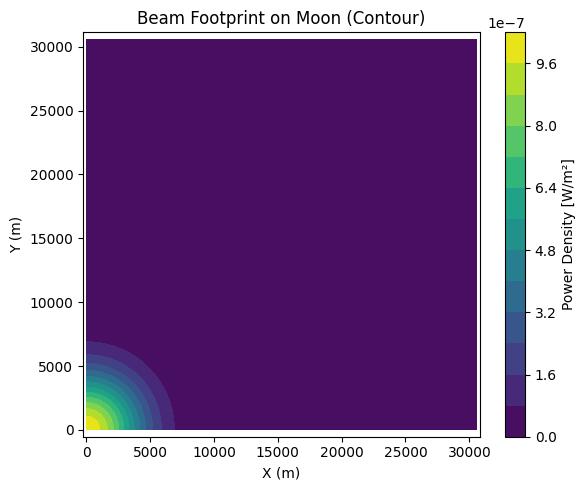

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

# Constants
distance = 384400e3
J = 2048
xi_size = 10
xi = np.linspace(-xi_size / 2, xi_size / 2, J)
dx = xi[1] - xi[0]
edge_width = int(0.1 * J)
window = np.hanning(2 * edge_width)
taper = np.ones(J)
taper[:edge_width] = window[:edge_width]
taper[-edge_width:] = window[-edge_width:]

def simulate_power_density(λ, wf, P0):
    k0 = 2 * np.pi / λ
    Ef = 1 / wf * np.sqrt(2 * P0 / np.pi)
    zf = k0 * wf**2 / 2
    N = 20000
    zeta_max = np.arctan(distance / zf)
    dt = zeta_max / (N - 1)
    sigma = 1j * dt / (4 * dx**2)

    main_A = (1 + 2 * sigma) - 1j * dt * (1 - xi**2)
    main_B = (1 - 2 * sigma) + 1j * dt * (1 - xi**2)
    off_A = np.full(J - 1, -sigma)
    off_B = np.full(J - 1, sigma)
    off_A[0] = off_A[-1] = -2 * sigma
    off_B[0] = off_B[-1] = 2 * sigma

    A_sparse = diags([off_A, main_A, off_A], [-1, 0, 1], format='csc')
    B_sparse = diags([off_B, main_B, off_B], [-1, 0, 1], format='csc')
    A_lu = splu(A_sparse)

    C = np.exp(-xi**2)
    s = [C.copy()]
    for _ in range(N - 1):
        rhs = B_sparse @ (C * taper)
        C = A_lu.solve(rhs)
        s.append(C.copy())

    def x(z_tilda): return xi * np.sqrt(1 + (z_tilda**2 / zf**2)) * wf
    def translate(z_tilda):
        z = z_tilda / zf
        zeta = np.arctan(z)
        j = int(zeta / dt)
        j = min(j, len(s) - 1)
        C_val = s[j]
        E = 1 / np.sqrt(1 + z**2) * np.exp(1j * (xi**2 * (1 + z**2) / (z + 1 / z) - zeta))
        return np.abs(C_val * Ef * E)**2

    r_vals = x(distance)
    I_vals = translate(distance)
    power_density_peak = I_vals.max()
    power_density_avg = trapezoid(I_vals * 2 * np.pi * r_vals, r_vals) / (np.pi * r_vals.max()**2)
    return power_density_peak, power_density_avg, r_vals.max(), r_vals, I_vals

# Sweep for table
wavelengths = [500e-9]
waists = [1e-2]
powers = [60]

results = []
for lam in wavelengths:
    for w0 in waists:
        for P0 in powers:
            peak, avg, spot_radius, r_vals, I_vals = simulate_power_density(lam, w0, P0)
            results.append({
                "λ (nm)": int(lam * 1e9),
                "w₀ (mm)": int(w0 * 1e3),
                "P₀ (MW)": P0 / 1e6,
                "Peak Power Density (W/m²)": peak,
                "Spot Radius on Moon (m)": spot_radius
            })

df = pd.DataFrame(results)
print("=== Gaussian Beam Power Density at Moon ===")
print(df.to_string(index=False))

# Plot contour of final beam
R = np.linspace(0, r_vals.max(), 300)
X, Y = np.meshgrid(R, R)
R2D = np.sqrt(X**2 + Y**2)
I_interp = interp1d(r_vals, I_vals, bounds_error=False, fill_value=0)
Z = I_interp(R2D)

plt.figure(figsize=(6, 5))
cs = plt.contourf(X, Y, Z, levels=15, cmap="viridis")
plt.colorbar(cs, label="Power Density [W/m²]")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Beam Footprint on Moon (Contour)")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from scipy.integrate import trapezoid

# Analytical minimum power formula
def compute_min_power_analytic(λ, w0, D=384400e3, I_target=1.0):
    z_R = np.pi * w0**2 / λ
    w_D = w0 * np.sqrt(1 + (D / z_R)**2)
    return (np.pi / 2) * w_D**2 * I_target

# CN simulation
def simulate_power_density(λ, wf, P0, D=384400e3):
    J = 2048
    xi = np.linspace(-10/2, 10/2, J)
    dx = xi[1] - xi[0]
    k0 = 2 * np.pi / λ
    Ef = 1 / wf * np.sqrt(2 * P0 / np.pi)
    zf = k0 * wf**2 / 2
    N = 20000
    zeta_max = np.arctan(D / zf)
    dt = zeta_max / (N - 1)
    sigma = 1j * dt / (4 * dx**2)

    taper = np.ones(J)
    edge_width = int(0.1 * J)
    window = np.hanning(2 * edge_width)
    taper[:edge_width] = window[:edge_width]
    taper[-edge_width:] = window[-edge_width:]

    main_A = (1 + 2 * sigma) - 1j * dt * (1 - xi**2)
    main_B = (1 - 2 * sigma) + 1j * dt * (1 - xi**2)
    off_A = np.full(J - 1, -sigma)
    off_B = np.full(J - 1, sigma)
    off_A[0] = off_A[-1] = -2 * sigma
    off_B[0] = off_B[-1] = 2 * sigma

    A_sparse = diags([off_A, main_A, off_A], [-1, 0, 1], format='csc')
    B_sparse = diags([off_B, main_B, off_B], [-1, 0, 1], format='csc')
    A_lu = splu(A_sparse)

    C = np.exp(-xi**2)
    s = [C.copy()]
    for _ in range(N - 1):
        rhs = B_sparse @ (C * taper)
        C = A_lu.solve(rhs)
        s.append(C.copy())

    def x(z): return xi * np.sqrt(1 + (z**2 / zf**2)) * wf
    def translate(z):
        zeta = np.arctan(z / zf)
        j = int(zeta / dt)
        j = min(j, len(s) - 1)
        C_val = s[j]
        E = 1 / np.sqrt(1 + (z / zf)**2) * np.exp(1j * (xi**2 * (1 + (z / zf)**2) / (z / zf + 1 / (z / zf)) - zeta))
        return np.abs(C_val * Ef * E)**2

    r_vals = x(D)
    I_vals = translate(D)
    peak = I_vals.max()
    avg = trapezoid(I_vals * 2 * np.pi * r_vals, r_vals) / (np.pi * r_vals.max()**2)
    return peak, avg, r_vals.max()

# === Parameter sweep ===
target_cases = {
    "LLR": 1e-6,
    "Comm": 1e-3,
    "Heating": 1e3
}

wavelengths = [400e-9, 500e-9, 600e-9]  # meters
waists = [0.005, 0.01]  # meters

results = []

for case, Itarget in target_cases.items():
    for λ in wavelengths:
        for w0 in waists:
            P0_min = compute_min_power_analytic(λ, w0, I_target=Itarget)
            for scale in [1, 2]:
                P0 = P0_min * scale
                peak, avg, spot_radius = simulate_power_density(λ, w0, P0)
                results.append({
                    "Case": case,
                    "λ (nm)": int(λ * 1e9),
                    "w₀ (mm)": int(w0 * 1e3),
                    "I_target (W/m²)": f"{Itarget:.1e}",
                    "P₀ (W)": f"{P0:.1e}",
                    "Peak Power Density (W/m²)": f"{peak:.2e}",
                    "Spot Radius on Moon (m)": f"{spot_radius:.2f}"
                })

df = pd.DataFrame(results)
print(df.to_string(index=False))


   Case  λ (nm)  w₀ (mm) I_target (W/m²)  P₀ (W) Peak Power Density (W/m²) Spot Radius on Moon (m)
    LLR     400        5         1.0e-06 1.5e+02                  1.00e-06                48943.33
    LLR     400        5         1.0e-06 3.0e+02                  2.00e-06                48943.33
    LLR     400       10         1.0e-06 3.8e+01                  1.00e-06                24471.66
    LLR     400       10         1.0e-06 7.5e+01                  2.00e-06                24471.66
    LLR     500        5         1.0e-06 2.4e+02                  1.00e-06                61179.16
    LLR     500        5         1.0e-06 4.7e+02                  2.00e-06                61179.16
    LLR     500       10         1.0e-06 5.9e+01                  1.00e-06                30589.58
    LLR     500       10         1.0e-06 1.2e+02                  2.00e-06                30589.58
    LLR     600        5         1.0e-06 3.4e+02                  1.00e-06                73414.99
    LLR   

# Part 4: Change of envelopes

### 1. Super-Gaussian

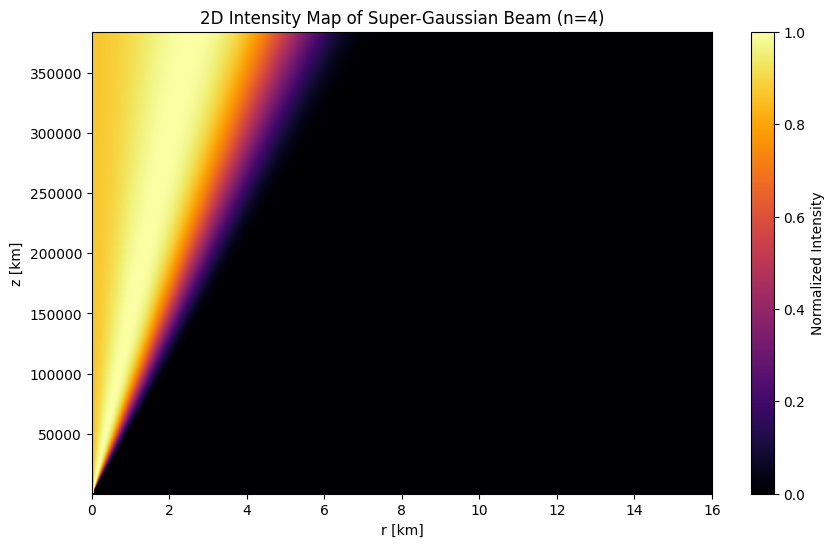

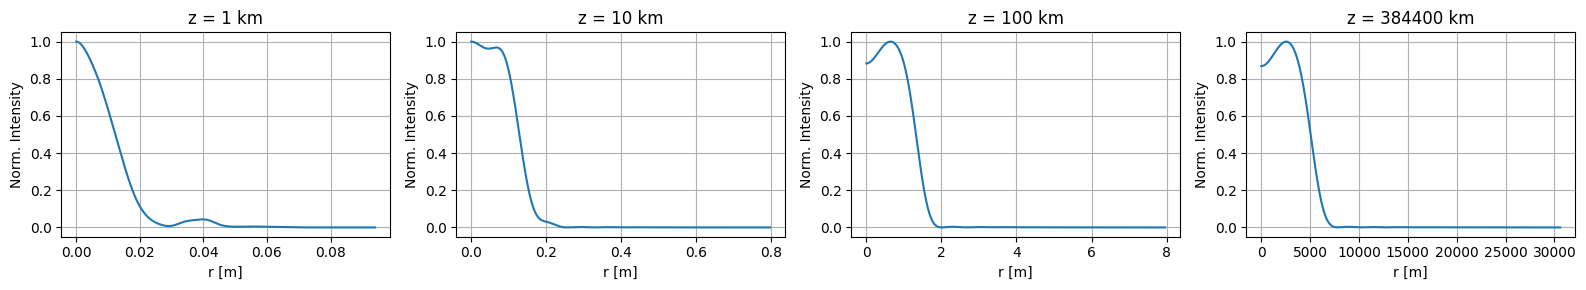

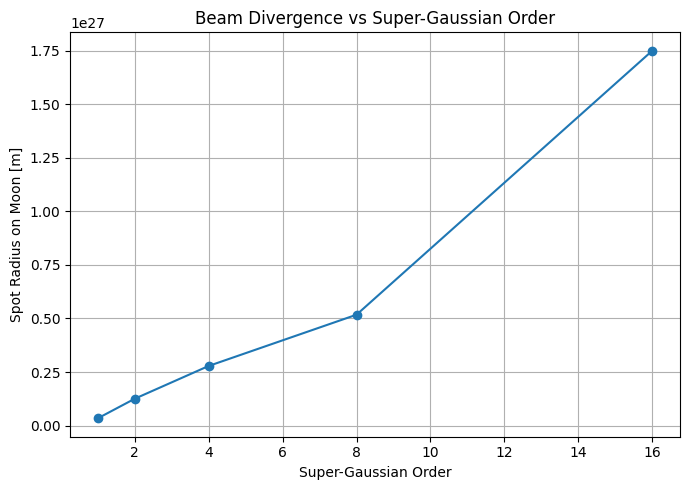

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from scipy.interpolate import interp1d

# ------------------- FIXED PARAMETERS -------------------
λ = 500e-9
k0 = 2 * np.pi / λ
wf = 1e-2
P0 = 1e-2
Ef = 1 / wf * np.sqrt(2 * P0 / np.pi)
zf = k0 * wf**2 / 2

J = 2048
xi_size = 10
xi = np.linspace(-xi_size / 2, xi_size / 2, J)
dx = xi[1] - xi[0]

distance = 384400e3
N = 20000
zeta_max = np.arctan(distance / zf)
dt = zeta_max / (N - 1)
sigma = 1j * dt / (4 * dx**2)

main_A = (1 + 2 * sigma) - 1j * dt * (1 - xi**2)
main_B = (1 - 2 * sigma) + 1j * dt * (1 - xi**2)
off_A = np.full(J - 1, -sigma)
off_B = np.full(J - 1, sigma)
off_A[0] = off_A[-1] = -2 * sigma
off_B[0] = off_B[-1] = 2 * sigma

A_sparse = diags([off_A, main_A, off_A], [-1, 0, 1], format='csc')
B_sparse = diags([off_B, main_B, off_B], [-1, 0, 1], format='csc')
A_lu = splu(A_sparse)

taper = np.ones(J)
edge_width = int(0.1 * J)
window = np.hanning(2 * edge_width)
taper[:edge_width] = window[:edge_width]
taper[-edge_width:] = window[-edge_width:]

# ------------------- FUNCTIONS -------------------
def super_gaussian(order):
    return np.exp(-xi**(2 * order))

def simulate_envelope(C_init):
    C = C_init.copy()
    s_local = [C.copy()]
    for _ in range(N - 1):
        rhs = B_sparse @ (C * taper)
        C = A_lu.solve(rhs)
        s_local.append(C.copy())
    return s_local

def x(z_tilda):
    return xi * np.sqrt(1 + (z_tilda**2 / zf**2)) * wf

def translate(z_tilda, s):
    z = z_tilda / zf
    zeta = np.arctan(z)
    j = int(zeta / dt)
    j = min(j, len(s) - 1)
    C_val = s[j]
    E = 1 / np.sqrt(1 + z**2) * np.exp(1j * (xi**2 * (1 + z**2) / (z + 1 / z) - zeta))
    return np.abs(C_val * Ef * E)**2

# ------------------- SIMULATION FOR ORDER 4 -------------------
C0 = super_gaussian(order=4)
s = simulate_envelope(C0)

# --------- Plot 1: 2D Color Mesh ---------
z_vals = np.linspace(2e3, distance, 500)
r_vals = np.linspace(0, 16000, 600)
intensity_map = np.zeros((len(z_vals), len(r_vals)))

for i, z in enumerate(z_vals):
    I = translate(z, s)
    r_at_z = x(z)
    interp_I = np.interp(r_vals, r_at_z[r_at_z >= 0], I[r_at_z >= 0], left=0, right=0)
    intensity_map[i] = interp_I / np.max(interp_I) if np.max(interp_I) > 0 else 0

plt.figure(figsize=(10, 6))
plt.imshow(intensity_map, extent=[r_vals[0]/1e3, r_vals[-1]/1e3, z_vals[0]/1e3, z_vals[-1]/1e3],
           aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Normalized Intensity")
plt.xlabel("r [km]")
plt.ylabel("z [km]")
plt.title("2D Intensity Map of Super-Gaussian Beam (n=4)")
plt.show()

# --------- Plot 2: Four Side-by-Side Intensity Profiles ---------
z_list = [1e3, 1e4, 1e5, distance]
titles = [f"z = {z/1e3:.0f} km" for z in z_list]

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for ax, z, title in zip(axes, z_list, titles):
    r_vals = x(z)
    I_vals = translate(z, s)
    r_pos = r_vals >= 0
    I_norm = I_vals / np.max(I_vals)
    ax.plot(r_vals[r_pos], I_norm[r_pos])
    ax.set_title(title)
    ax.set_xlabel("r [m]")
    ax.set_ylabel("Norm. Intensity")
    ax.grid(True)

plt.tight_layout()
plt.show()

# --------- Plot 3: Beam Divergence vs Order ---------
orders = [1, 2, 4, 8, 16]
spot_radii = []
for order in orders:
    C0 = super_gaussian(order)
    s_local = simulate_envelope(C0)
    I = translate(distance, s_local)
    r_moon = x(distance)
    interp_I = interp1d(I[::-1], r_moon[::-1], fill_value="extrapolate", bounds_error=False)
    spot_radius = interp_I(0.5)
    spot_radii.append(np.abs(spot_radius))

plt.figure(figsize=(7, 5))
plt.plot(orders, spot_radii, 'o-')
plt.xlabel("Super-Gaussian Order")
plt.ylabel("Spot Radius on Moon [m]")
plt.title("Beam Divergence vs Super-Gaussian Order")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Square wave

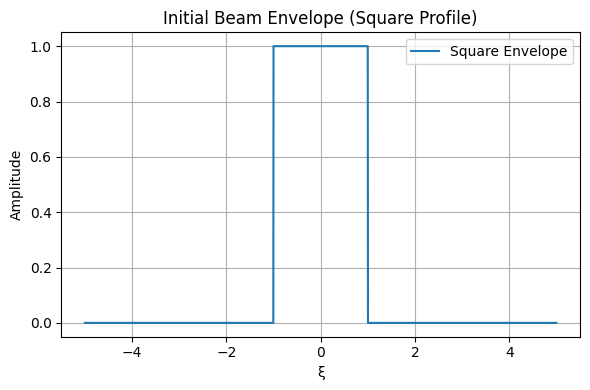

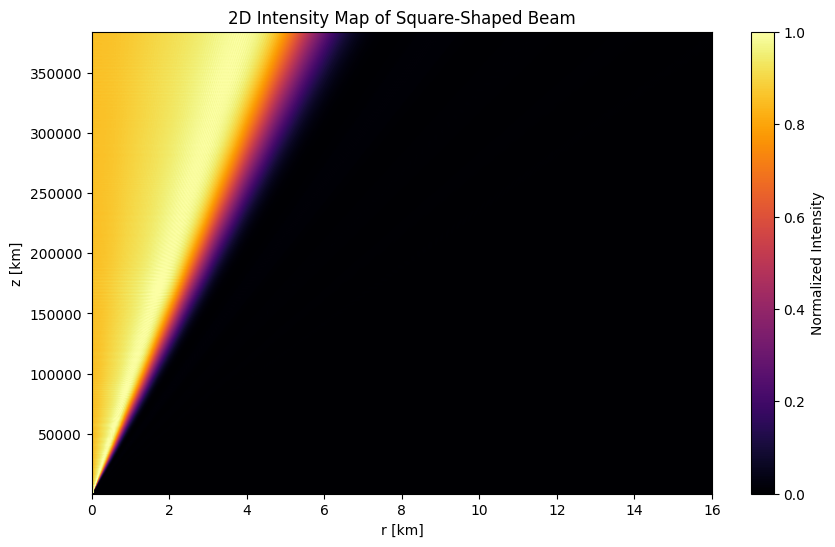

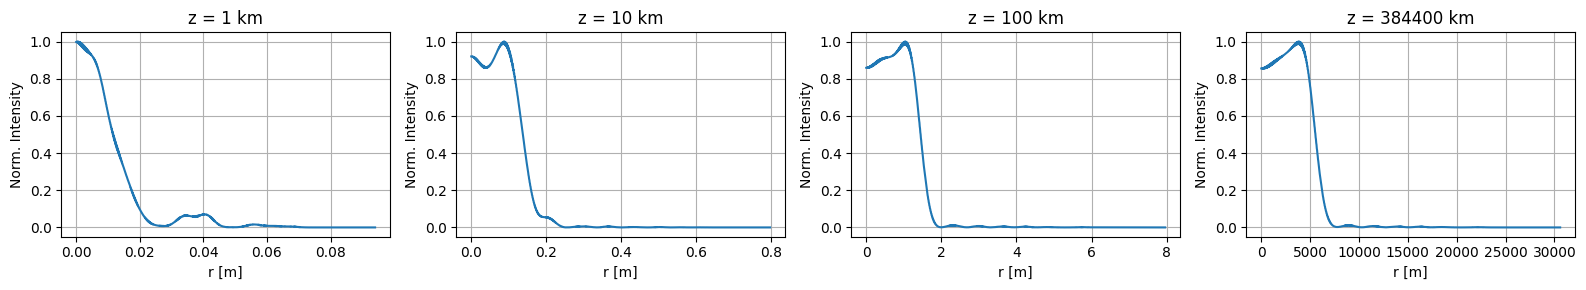

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from scipy.interpolate import interp1d

# ------------------- FIXED PARAMETERS -------------------
λ = 500e-9
k0 = 2 * np.pi / λ
wf = 1e-2
P0 = 1e-2
Ef = 1 / wf * np.sqrt(2 * P0 / np.pi)
zf = k0 * wf**2 / 2

J = 2048
xi_size = 10
xi = np.linspace(-xi_size / 2, xi_size / 2, J)
dx = xi[1] - xi[0]

distance = 384400e3
N = 20000
zeta_max = np.arctan(distance / zf)
dt = zeta_max / (N - 1)
sigma = 1j * dt / (4 * dx**2)

main_A = (1 + 2 * sigma) - 1j * dt * (1 - xi**2)
main_B = (1 - 2 * sigma) + 1j * dt * (1 - xi**2)
off_A = np.full(J - 1, -sigma)
off_B = np.full(J - 1, sigma)
off_A[0] = off_A[-1] = -2 * sigma
off_B[0] = off_B[-1] = 2 * sigma

A_sparse = diags([off_A, main_A, off_A], [-1, 0, 1], format='csc')
B_sparse = diags([off_B, main_B, off_B], [-1, 0, 1], format='csc')
A_lu = splu(A_sparse)

taper = np.ones(J)
edge_width = int(0.1 * J)
window = np.hanning(2 * edge_width)
taper[:edge_width] = window[:edge_width]
taper[-edge_width:] = window[-edge_width:]

# ------------------- FUNCTIONS -------------------
def square_envelope():
    profile = np.zeros_like(xi)
    width = 2.0  # full width of square
    profile[np.abs(xi) < width / 2] = 1.0
    return profile

def simulate_envelope(C_init):
    C = C_init.copy()
    s_local = [C.copy()]
    for _ in range(N - 1):
        rhs = B_sparse @ (C * taper)
        C = A_lu.solve(rhs)
        s_local.append(C.copy())
    return s_local

def x(z_tilda):
    return xi * np.sqrt(1 + (z_tilda**2 / zf**2)) * wf

def translate(z_tilda, s):
    z = z_tilda / zf
    zeta = np.arctan(z)
    j = int(zeta / dt)
    j = min(j, len(s) - 1)
    C_val = s[j]
    E = 1 / np.sqrt(1 + z**2) * np.exp(1j * (xi**2 * (1 + z**2) / (z + 1 / z) - zeta))
    return np.abs(C_val * Ef * E)**2

# ------------------- INITIAL BEAM PROFILE -------------------
C0 = square_envelope()

plt.figure(figsize=(6, 4))
plt.plot(xi, C0, label="Square Envelope")
plt.title("Initial Beam Envelope (Square Profile)")
plt.xlabel("ξ")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- PROPAGATION -------------------
s = simulate_envelope(C0)

# --------- Plot 1: 2D Color Mesh ---------
z_vals = np.linspace(2e3, distance, 500)
r_vals = np.linspace(0, 16000, 600)
intensity_map = np.zeros((len(z_vals), len(r_vals)))

for i, z in enumerate(z_vals):
    I = translate(z, s)
    r_at_z = x(z)
    interp_I = np.interp(r_vals, r_at_z[r_at_z >= 0], I[r_at_z >= 0], left=0, right=0)
    intensity_map[i] = interp_I / np.max(interp_I) if np.max(interp_I) > 0 else 0

plt.figure(figsize=(10, 6))
plt.imshow(intensity_map, extent=[r_vals[0]/1e3, r_vals[-1]/1e3, z_vals[0]/1e3, z_vals[-1]/1e3],
           aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Normalized Intensity")
plt.xlabel("r [km]")
plt.ylabel("z [km]")
plt.title("2D Intensity Map of Square-Shaped Beam")
plt.show()

# --------- Plot 2: Four Side-by-Side Intensity Profiles ---------
z_list = [1e3, 1e4, 1e5, distance]
titles = [f"z = {z/1e3:.0f} km" for z in z_list]

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for ax, z, title in zip(axes, z_list, titles):
    r_vals = x(z)
    I_vals = translate(z, s)
    r_pos = r_vals >= 0
    I_norm = I_vals / np.max(I_vals)
    ax.plot(r_vals[r_pos], I_norm[r_pos])
    ax.set_title(title)
    ax.set_xlabel("r [m]")
    ax.set_ylabel("Norm. Intensity")
    ax.grid(True)

plt.tight_layout()
plt.show()

### 3. Gaussian with noise

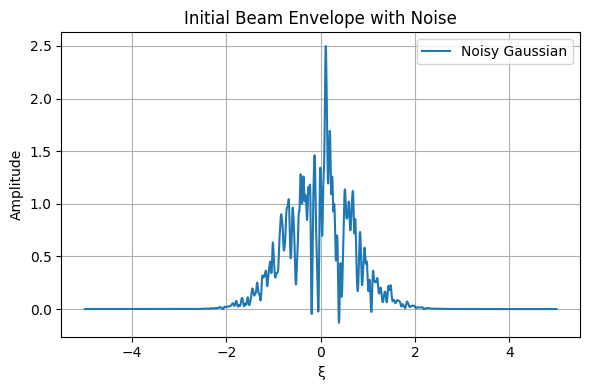

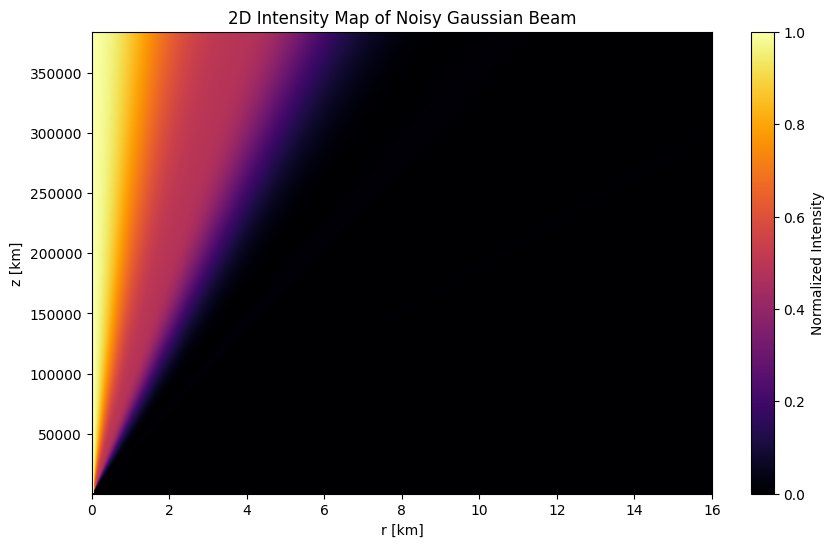

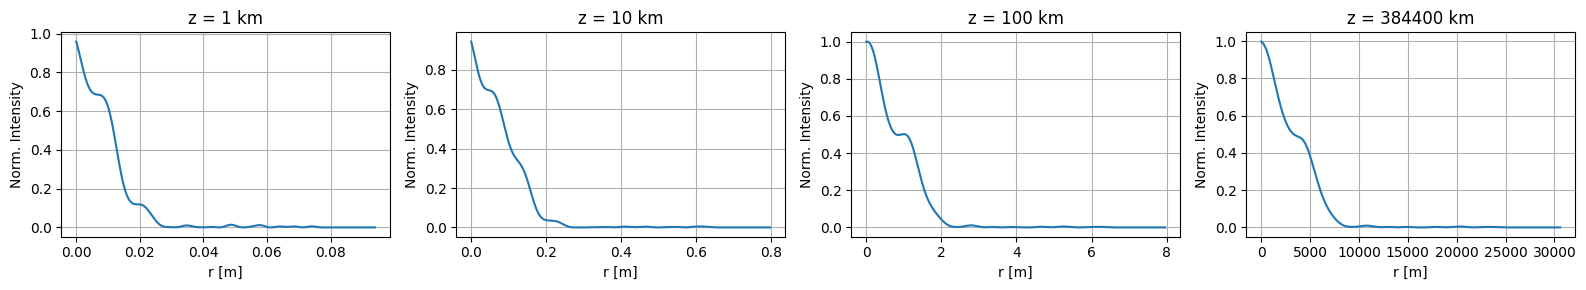

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from scipy.interpolate import interp1d

# ------------------- FIXED PARAMETERS -------------------
λ = 500e-9
k0 = 2 * np.pi / λ
wf = 1e-2
P0 = 1e-2
Ef = 1 / wf * np.sqrt(2 * P0 / np.pi)
zf = k0 * wf**2 / 2

J = 2048
xi_size = 10
xi = np.linspace(-xi_size / 2, xi_size / 2, J)
dx = xi[1] - xi[0]

distance = 384400e3
N = 20000
zeta_max = np.arctan(distance / zf)
dt = zeta_max / (N - 1)
sigma = 1j * dt / (4 * dx**2)

main_A = (1 + 2 * sigma) - 1j * dt * (1 - xi**2)
main_B = (1 - 2 * sigma) + 1j * dt * (1 - xi**2)
off_A = np.full(J - 1, -sigma)
off_B = np.full(J - 1, sigma)
off_A[0] = off_A[-1] = -2 * sigma
off_B[0] = off_B[-1] = 2 * sigma

A_sparse = diags([off_A, main_A, off_A], [-1, 0, 1], format='csc')
B_sparse = diags([off_B, main_B, off_B], [-1, 0, 1], format='csc')
A_lu = splu(A_sparse)

taper = np.ones(J)
edge_width = int(0.1 * J)
window = np.hanning(2 * edge_width)
taper[:edge_width] = window[:edge_width]
taper[-edge_width:] = window[-edge_width:]

# ------------------- FUNCTIONS -------------------
def natural_noisy_gaussian_envelope():
    clean = np.exp(-xi**2)
    base_noise = (np.random.randn(J) * 1.5)
    low_freq_noise = gaussian_filter1d(base_noise, sigma=3)
    high_freq = 0.05 * np.sin(10 * xi + 2 * np.pi * np.random.rand())
    combined_noise = low_freq_noise + high_freq
    return clean * (1 + combined_noise)

def simulate_envelope(C_init):
    C = C_init.copy()
    s_local = [C.copy()]
    for _ in range(N - 1):
        rhs = B_sparse @ (C * taper)
        C = A_lu.solve(rhs)
        s_local.append(C.copy())
    return s_local

def x(z_tilda):
    return xi * np.sqrt(1 + (z_tilda**2 / zf**2)) * wf

def translate(z_tilda, s):
    z = z_tilda / zf
    zeta = np.arctan(z)
    j = int(zeta / dt)
    j = min(j, len(s) - 1)
    C_val = s[j]
    E = 1 / np.sqrt(1 + z**2) * np.exp(1j * (xi**2 * (1 + z**2) / (z + 1 / z) - zeta))
    return np.abs(C_val * Ef * E)**2

# ------------------- INITIAL BEAM PROFILE -------------------
C0 = natural_noisy_gaussian_envelope()

plt.figure(figsize=(6, 4))
plt.plot(xi, C0, label="Noisy Gaussian")
plt.title("Initial Beam Envelope with Noise")
plt.xlabel("ξ")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- PROPAGATION -------------------
s = simulate_envelope(C0)

# --------- Plot 2D Color Mesh ---------
z_vals = np.linspace(2e3, distance, 500)
r_vals = np.linspace(0, 16000, 600)
intensity_map = np.zeros((len(z_vals), len(r_vals)))

for i, z in enumerate(z_vals):
    I = translate(z, s)
    r_at_z = x(z)
    interp_I = np.interp(r_vals, r_at_z[r_at_z >= 0], I[r_at_z >= 0], left=0, right=0)
    intensity_map[i] = interp_I / np.max(interp_I) if np.max(interp_I) > 0 else 0

plt.figure(figsize=(10, 6))
plt.imshow(intensity_map, extent=[r_vals[0]/1e3, r_vals[-1]/1e3, z_vals[0]/1e3, z_vals[-1]/1e3],
           aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Normalized Intensity")
plt.xlabel("r [km]")
plt.ylabel("z [km]")
plt.title("2D Intensity Map of Noisy Gaussian Beam")
plt.show()

# --------- Plot 4 Intensity Profiles ---------
z_list = [1e3, 1e4, 1e5, distance]
titles = [f"z = {z/1e3:.0f} km" for z in z_list]

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for ax, z, title in zip(axes, z_list, titles):
    r_vals = x(z)
    I_vals = translate(z, s)
    r_pos = r_vals >= 0
    I_norm = I_vals / np.max(I_vals)
    ax.plot(r_vals[r_pos], I_norm[r_pos])
    ax.set_title(title)
    ax.set_xlabel("r [m]")
    ax.set_ylabel("Norm. Intensity")
    ax.grid(True)

plt.tight_layout()
plt.show()